<a href="https://colab.research.google.com/github/tylee33/Paper_Research/blob/main/Gold_Darts_N_BEATS_BlockRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arxiv.org/pdf/1905.10437
https://github.com/DomS1080/Data-Science/blob/main/Projects/Supervised%20Learning/Time%20Series%20Forecasting/Gold%20Darts%20N-BEATS%20BlockRNN.ipynb


In [1]:
#Google Colab: Change runtime to T4 GPU

#Run once+comment out in new VM instance
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 50.7 MB/s eta 0:0

In [2]:
#General Imports
import yfinance as yf
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import torch as tc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
#Darts-related imports
from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging
logging.disable(logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

def generate_torch_kwargs():
    #Run torch models on GPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "gpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
#Specify commodity ticker(s)
gold_spot = yf.Ticker('GC=F')

#Fetch end date as string
 #Prediction period: August 1, 2023 - Oct 31, 2023
end_date = '2023-10-31'
pred_end_obj = datetime.strptime(end_date, '%Y-%m-%d')

#Set days to predict; create train + predict date ranges
tenYears = pred_end_obj-timedelta(days=((365*10)+2))
trainEnd = pred_end_obj-timedelta(days=92)
predStart = pred_end_obj-timedelta(days=91)
predEnd = pred_end_obj
predEnd2 = pred_end_obj+timedelta(days=1)

data_start_str = tenYears.strftime('%Y-%m-%d')
train_end_str = trainEnd.strftime('%Y-%m-%d')
pred_start_str = predStart.strftime('%Y-%m-%d')
pred_end_str = predEnd.strftime('%Y-%m-%d')
pred_end_str2 = predEnd2.strftime('%Y-%m-%d')

print('Training Data Start Date: '+data_start_str+'\nTraining Data End: '+train_end_str+'\nPrediction Range: '+pred_start_str+' to '+pred_end_str)


Training Data Start Date: 2013-10-31
Training Data End: 2023-07-31
Prediction Range: 2023-08-01 to 2023-10-31


In [5]:
#Create base datasets
 #Download full range of data (available data includes only weekdays/trading days)
  #n = 2514 observations is roughly as expected (2510 = 3650 - 1040 - 100)
   #total days = ~3650 (365 days * 10 years)
   #weekend days = ~1040 (2 days * 52 weeks * 10 years)
   #holidays = ~100 (10 statutory holiday market closures * 10 years)
gold_data = gold_spot.history(start=data_start_str, end=pred_end_str2)
print(pd.concat([gold_data.head(1),gold_data.tail(1)]))

                             Open    High          Low        Close  Volume  \
Date                                                                          
2013-10-31 00:00:00-04:00  1334.0  1334.0  1321.699951  1323.599976      62   
2023-10-31 00:00:00-04:00  1996.5  2001.0  1983.699951  1985.199951      84   

                           Dividends  Stock Splits  
Date                                                
2013-10-31 00:00:00-04:00        0.0           0.0  
2023-10-31 00:00:00-04:00        0.0           0.0  


In [6]:
#Simplify index
gold_data.index = gold_data.index.strftime('%Y-%m-%d')
#Create full df w/ attributes of interest
gold_df = gold_data[['Open','High','Low','Close','Volume']]
 #Review full df info
gold_df.info()
print(pd.concat([gold_df.head(2),gold_df.tail(2)]))

<class 'pandas.core.frame.DataFrame'>
Index: 2514 entries, 2013-10-31 to 2023-10-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2514 non-null   float64
 1   High    2514 non-null   float64
 2   Low     2514 non-null   float64
 3   Close   2514 non-null   float64
 4   Volume  2514 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.8+ KB
                   Open         High          Low        Close  Volume
Date                                                                  
2013-10-31  1334.000000  1334.000000  1321.699951  1323.599976      62
2013-11-01  1325.699951  1325.699951  1308.000000  1313.099976      21
2023-10-30  2004.099976  2004.099976  1992.500000  1996.199951     157
2023-10-31  1996.500000  2001.000000  1983.699951  1985.199951      84


In [7]:
#Check for missing values within retrieved data
gold_df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [8]:
#Filter dataset (retaining 'Close' spot price)
df_g_darts = gold_df[['Close']]

 #Check index dtype
df_g_darts.index

Index(['2013-10-31', '2013-11-01', '2013-11-04', '2013-11-05', '2013-11-06',
       '2013-11-07', '2013-11-08', '2013-11-11', '2013-11-12', '2013-11-13',
       ...
       '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-23', '2023-10-24',
       '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-30', '2023-10-31'],
      dtype='object', name='Date', length=2514)

In [9]:
#Convert index to RangeIndex dtype (integer format)
df_g_darts = df_g_darts.reset_index()
 #Check values
print(pd.concat([df_g_darts.head(1),df_g_darts.tail(1)]))

            Date        Close
0     2013-10-31  1323.599976
2513  2023-10-31  1985.199951


In [10]:
#Filter out 'Date' column (previous index)
df_g_darts = df_g_darts[['Close']]
 #Check values
print(pd.concat([df_g_darts.head(1),df_g_darts.tail(1)]))

            Close
0     1323.599976
2513  1985.199951


In [11]:
#Verify correct index dtype
df_g_darts.index

RangeIndex(start=0, stop=2514, step=1)

In [12]:
#Convert Gold df to Darts TimeSeries object
g_series = TimeSeries.from_dataframe(df_g_darts)
g_series

<TimeSeries (DataArray) (time: 2514, component: 1, sample: 1)> Size: 20kB
array([[[1323.59997559]],

       [[1313.09997559]],

       [[1314.59997559]],

       ...,

       [[1988.59997559]],

       [[1996.19995117]],

       [[1985.19995117]]])
Coordinates:
  * time       (time) int64 20kB 0 1 2 3 4 5 6 ... 2508 2509 2510 2511 2512 2513
  * component  (component) object 8B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [13]:
#Scale Gold TimeSeries
scaler = Scaler()
g_series_sc = scaler.fit_transform(g_series)
g_series_sc

<TimeSeries (DataArray) (time: 2514, component: 1, sample: 1)> Size: 20kB
array([[[0.27260911]],

       [[0.26211646]],

       [[0.26361541]],

       ...,

       [[0.93714397]],

       [[0.94473863]],

       [[0.93374633]]])
Coordinates:
  * time       (time) int64 20kB 0 1 2 3 4 5 6 ... 2508 2509 2510 2511 2512 2513
  * component  (component) object 8B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='time'>

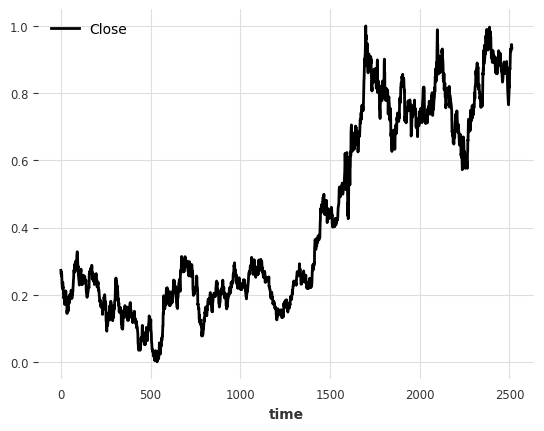

In [14]:
#Plot Gold 'Close' against time (days)
g_series_sc.plot(label='Close')

In [15]:
#Split series into train/test
 #Keep last 3 months for testing;
 #Weekdays (Aug, Sept, Oct 2023): 21+22+23 = 66 days

#Verify lengths
train_g_close, test_g_close = g_series_sc[:-66], g_series_sc[-66:]
len(train_g_close)

2448

In [16]:
len(test_g_close)

66

In [17]:
#Model 1: N-BEATS model predicting prior 3 mo. prices in 2*33 trading day cycles
 #Input_chunk_length: training data-prediction chunk length; 2448-33 = 2415
 #Output_chunk_length (prediction chunk length) = 33
model_past_close33 = NBEATSModel(
    input_chunk_length=2415,
    output_chunk_length=33,
    n_epochs=200,
    random_state=42,
    **generate_torch_kwargs()
)

In [18]:
#Fit training timeseries
model_past_close33.fit(train_g_close)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=2415, output_chunk_length=33, n_epochs=200, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7e590ffe21a0>]})

MAPE = 4.29%


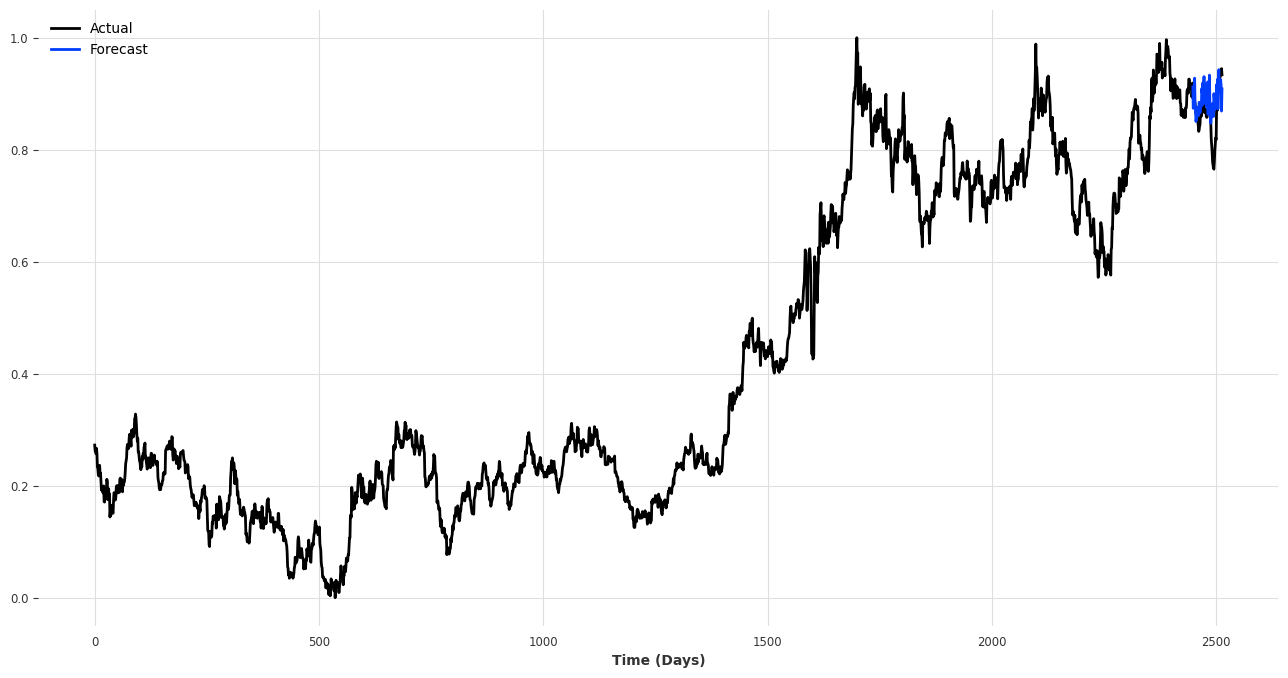

In [19]:
#Predict + score prediction error (Mean Average Percent Error) against scaled actuals
predPast33 = model_past_close33.predict(n=66)

plt.figure(figsize=(16,8))
g_series_sc.plot(label="Actual")
predPast33.plot(label='Forecast')
plt.xlabel('Time (Days)')
plt.legend()
print("MAPE = {:.2f}%".format(mape(g_series_sc, predPast33)))

In [20]:
#Model 2: N-BEATS model predicting prior 3 mo. prices in 1*66 trading day cycle
 #Input_chunk_length: training data-prediction chunk length; 2448-66 = 2382
 #Output_chunk_length (prediction chunk length) = 66
model_past_close66 = NBEATSModel(
    input_chunk_length=2382,
    output_chunk_length=66,
    n_epochs=200,
    random_state=42,
    **generate_torch_kwargs()
)

In [21]:
#Fit training timeseries
model_past_close66.fit(train_g_close)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=2382, output_chunk_length=66, n_epochs=200, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7e590eb8d030>]})

MAPE = 6.34%


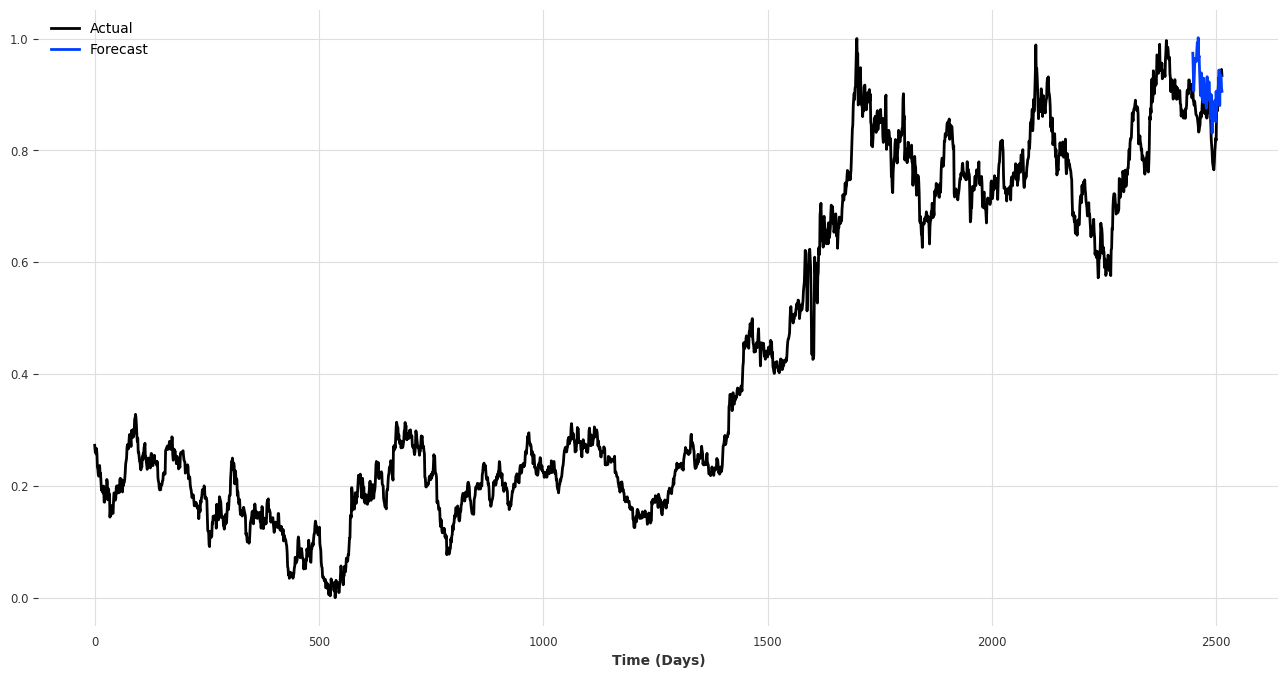

In [22]:
#Predict + score prediction error (Mean Average Percent Error) against scaled actuals
predPast66 = model_past_close66.predict(n=66)

plt.figure(figsize=(16,8))
g_series_sc.plot(label="Actual")
predPast66.plot(label='Forecast')
plt.xlabel('Time (Days)')
plt.legend()
print("MAPE = {:.2f}%".format(mape(g_series_sc, predPast66)))

In [23]:
#Model 3: NBeats model predicting future prices (3 mo.) in 2*33 trading day cycles
model_fut_close33 = NBEATSModel(
    input_chunk_length=2481,
    output_chunk_length=33,
    n_epochs=200,
    random_state=42,
    **generate_torch_kwargs()
)

In [24]:
#Fit full timeseries (ending Oct 31)
model_fut_close33.fit(g_series_sc)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=2481, output_chunk_length=33, n_epochs=200, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7e590e3898d0>]})

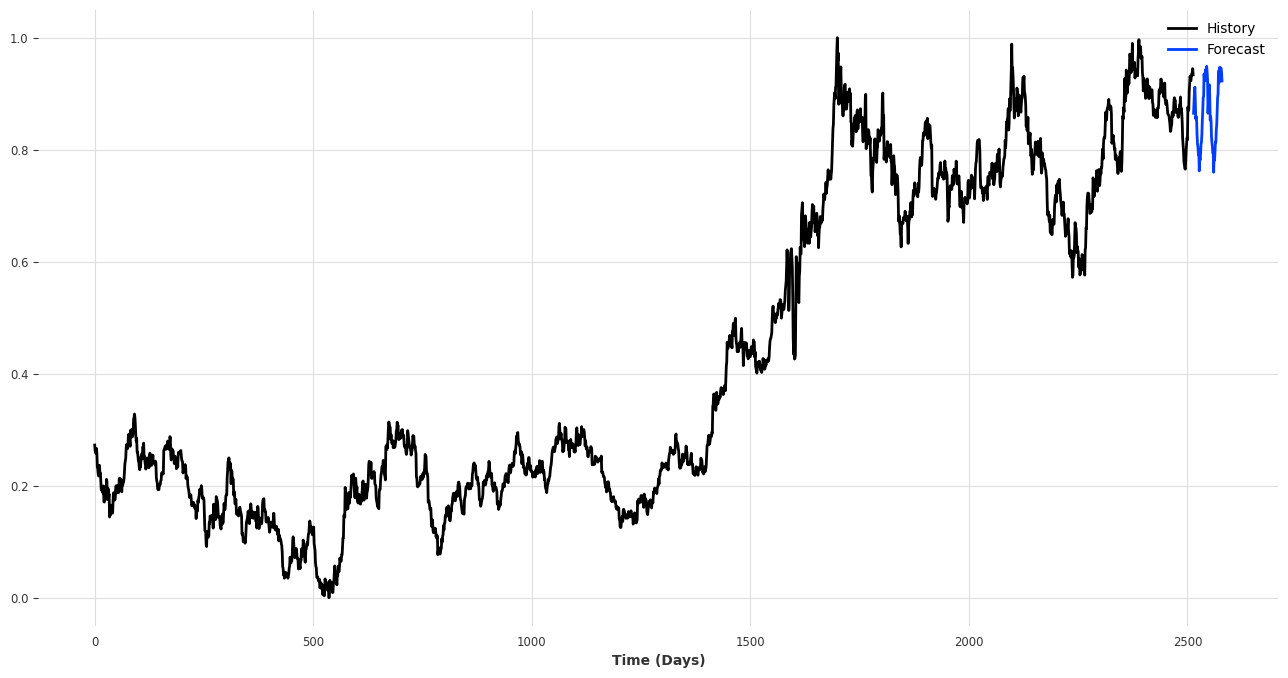

In [25]:
#Predict (cannot compare actuals at present)
 #Nov+Dec+Jan 2023: 22+21+22 = 65 work days; minus christmas+new years
  #66 days for an even number

predFut33 = model_fut_close33.predict(n=66)

plt.figure(figsize=(16,8))
g_series_sc.plot(label="History")
predFut33.plot(label='Forecast')
plt.xlabel('Time (Days)')
plt.legend()

In [26]:
#Model 4: NBeats model predicting future prices (3 mo.) in 1*66 trading day cycle
model_fut_close66 = NBEATSModel(
    input_chunk_length=2448,
    output_chunk_length=66,
    n_epochs=200,
    random_state=42,
    **generate_torch_kwargs()
)

In [27]:
#Fit full timeseries (ending Oct 31)
model_fut_close66.fit(g_series_sc)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=2448, output_chunk_length=66, n_epochs=200, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7e590e3a4970>]})

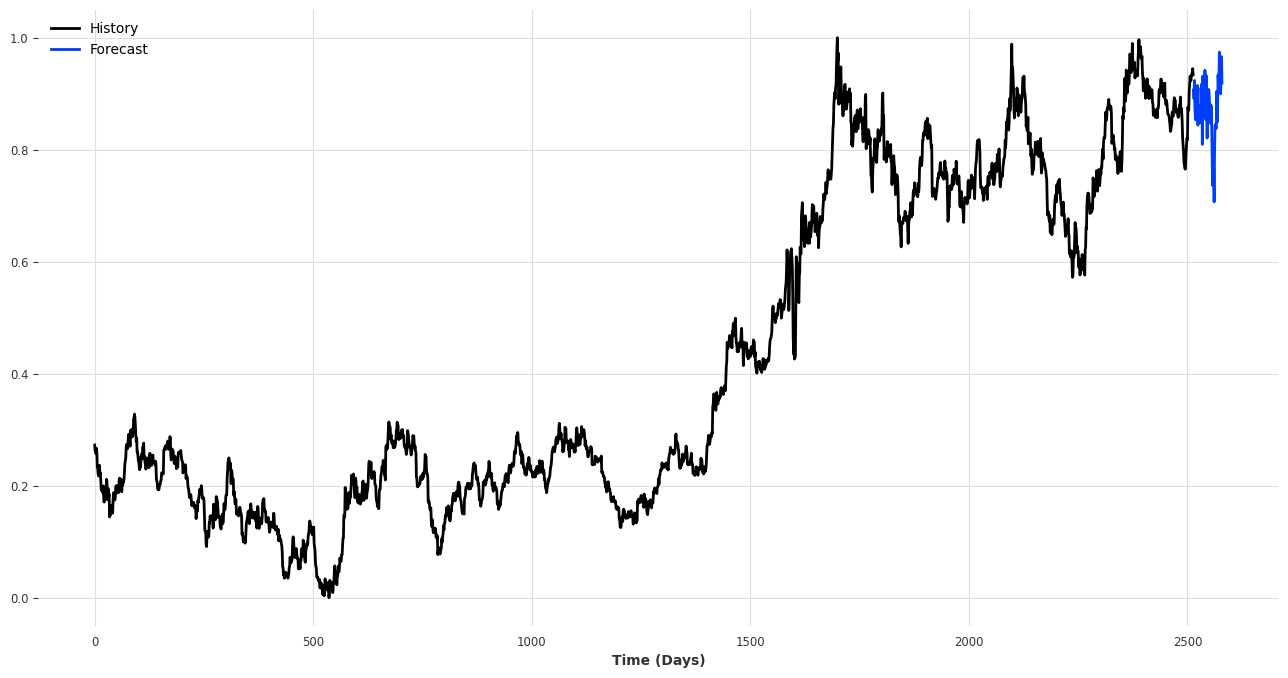

In [28]:
#Predict (cannot compare actuals at present)
predFut66 = model_fut_close66.predict(n=66)

plt.figure(figsize=(16,8))
g_series_sc.plot(label="History")
predFut66.plot(label='Forecast')
plt.xlabel('Time (Days)')
plt.legend()

In [29]:
#Selected Covariate data:
 #USD index: ('DX=F')
 #Large publically-traded jewelery company: Signet Jewelers ('SIG')
 #US monthly inflation measure: Volatility Index ('VIX')
usd_indx = yf.Ticker('DX=F')
sig_indx = yf.Ticker('SIG')
vol_indx = yf.Ticker('^VIX')

In [30]:
#Import covariate data 1: USD

usd_data = usd_indx.history(start=data_start_str, end=pred_end_str2)
 #Simplify index
usd_data.index = usd_data.index.strftime('%Y-%m-%d')
 #Create full df w/ attributes of interest
usd_df = usd_data[['Open','High','Low','Close','Volume']]
 #Review df info
usd_df.info()
print(pd.concat([usd_df.head(2),usd_df.tail(2)]))

<class 'pandas.core.frame.DataFrame'>
Index: 2513 entries, 2013-10-31 to 2023-10-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2513 non-null   float64
 1   High    2513 non-null   float64
 2   Low     2513 non-null   float64
 3   Close   2513 non-null   float64
 4   Volume  2513 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.8+ KB
                  Open        High         Low       Close  Volume
Date                                                              
2013-10-31   79.820000   80.355003   79.739998   80.263000   26159
2013-11-01   80.330002   80.870003   80.320000   80.809998   17473
2023-10-30  106.379997  106.529999  105.875000  105.933998   13059
2023-10-31  105.995003  106.690002  105.724998  106.494003   18445


In [31]:
#Import covariate data 2: Signet Jewelers

sig_data = sig_indx.history(start=data_start_str, end=pred_end_str2)
 #Simplify index
sig_data.index = sig_data.index.strftime('%Y-%m-%d')
 #Create full df w/ attributes of interest
sig_df = sig_data[['Open','High','Low','Close','Volume']]
 #Review df info
sig_df.info()
print(pd.concat([sig_df.head(2),sig_df.tail(2)]))

<class 'pandas.core.frame.DataFrame'>
Index: 2517 entries, 2013-10-31 to 2023-10-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2517 non-null   float64
 1   High    2517 non-null   float64
 2   Low     2517 non-null   float64
 3   Close   2517 non-null   float64
 4   Volume  2517 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.0+ KB
                 Open       High        Low      Close  Volume
Date                                                          
2013-10-31  62.825250  63.075912  62.240359  62.382408  957700
2013-11-01  62.608008  63.226315  62.198588  62.850319  635400
2023-10-30  67.572083  69.455420  67.016997  68.791298  561500
2023-10-31  68.394807  69.742880  67.383757  69.217529  606700


In [32]:
#Import covariate data 3: Volatility

vol_data = vol_indx.history(start=data_start_str, end=pred_end_str2)
 #Simplify index
vol_data.index = vol_data.index.strftime('%Y-%m-%d')
 #Create full df w/ attributes of interest
vol_df = vol_data[['Open','High','Low','Close','Volume']]
 #Review df info
vol_df.info()
print(pd.concat([vol_df.head(2),vol_df.tail(2)]))

<class 'pandas.core.frame.DataFrame'>
Index: 2517 entries, 2013-10-31 to 2023-10-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2517 non-null   float64
 1   High    2517 non-null   float64
 2   Low     2517 non-null   float64
 3   Close   2517 non-null   float64
 4   Volume  2517 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.0+ KB
                 Open       High        Low      Close  Volume
Date                                                          
2013-10-31  13.830000  14.020000  13.280000  13.750000       0
2013-11-01  13.460000  13.920000  13.220000  13.280000       0
2023-10-30  21.129999  21.160000  19.549999  19.750000       0
2023-10-31  19.860001  19.860001  17.969999  18.139999       0


In [33]:
#Filter datasets (retaining 'Close' values)
 #Shorten all to same length for Darts; 2513
df_g_darts2 = gold_df[['Close']][:-1]

df_vix_darts = vol_df[['Close']][:-4]
df_usd_darts = usd_df[['Close']]
df_sig_darts = sig_df[['Close']][:-4]

In [34]:
#Convert Gold+Covariate df indexes to RangeIndex dtype (integer format)
df_g_darts2 = df_g_darts2.reset_index()
 #Check values
print(pd.concat([df_g_darts2.head(1),df_g_darts2.tail(1)]))

            Date        Close
0     2013-10-31  1323.599976
2512  2023-10-30  1996.199951


In [35]:
df_vix_darts = df_vix_darts.reset_index()
 #Check values
print(pd.concat([df_vix_darts.head(1),df_vix_darts.tail(1)]))

            Date      Close
0     2013-10-31  13.750000
2512  2023-10-25  20.190001


In [36]:
df_usd_darts = df_usd_darts.reset_index()
 #Check values
print(pd.concat([df_usd_darts.head(1),df_usd_darts.tail(1)]))

            Date       Close
0     2013-10-31   80.263000
2512  2023-10-31  106.494003


In [37]:
df_sig_darts = df_sig_darts.reset_index()
 #Check values
print(pd.concat([df_sig_darts.head(1),df_sig_darts.tail(1)]))

            Date      Close
0     2013-10-31  62.382408
2512  2023-10-25  69.128319


In [38]:
#Filter out 'Date' column (previous index)

df_g_darts2 = df_g_darts2[['Close']]
df_usd_darts = df_usd_darts[['Close']]
df_sig_darts = df_sig_darts[['Close']]
df_vix_darts = df_vix_darts[['Close']]
 #Check values
print(pd.concat([df_g_darts2.head(1),df_g_darts2.tail(1)]))
print(pd.concat([df_usd_darts.head(1),df_usd_darts.tail(1)]))
print(pd.concat([df_sig_darts.head(1),df_sig_darts.tail(1)]))
print(pd.concat([df_vix_darts.head(1),df_vix_darts.tail(1)]))

            Close
0     1323.599976
2512  1996.199951
           Close
0      80.263000
2512  106.494003
          Close
0     62.382408
2512  69.128319
          Close
0     13.750000
2512  20.190001


In [39]:
#Convert Gold+Covariate dfs to Darts TimeSeries objects
g_series2 = TimeSeries.from_dataframe(df_g_darts2)
usd_series = TimeSeries.from_dataframe(df_usd_darts)
sig_series = TimeSeries.from_dataframe(df_sig_darts)
vix_series = TimeSeries.from_dataframe(df_vix_darts)

In [40]:
#Train/test splits
 #Train: all points up to prediction period start (Aug 1, 2023)
 #Test: all points from prediction period start to Oct 31, 2023
g_train2, g_test2 = g_series2[:-66], g_series2[-66:]
u_train_cov, u_test_cov = usd_series[:-66], usd_series[-66:]
s_train_cov, s_test_cov = sig_series[:-66], sig_series[-66:]
v_train_cov, v_test_cov = vix_series[:-66], vix_series[-66:]

In [41]:
print(len(u_train_cov))
print(len(s_train_cov))
print(len(v_train_cov))
print(len(u_test_cov))
print(len(s_test_cov))
print(len(v_test_cov))

2447
2447
2447
66
66
66


In [42]:
#Scale covariate train/test series
scaler_g2, scaler_usd, scaler_sig, scaler_vix = Scaler(), Scaler(), Scaler(), Scaler()

g_tr_sc = scaler_g2.fit_transform(g_train2)
u_tr_sc = scaler_usd.fit_transform(u_train_cov)
s_tr_sc = scaler_sig.fit_transform(s_train_cov)
v_tr_sc = scaler_vix.fit_transform(v_train_cov)

g_te_sc = scaler_g2.transform(g_test2)
u_te_sc = scaler_usd.transform(u_test_cov)
s_te_sc = scaler_sig.transform(s_test_cov)
v_te_sc = scaler_vix.transform(v_test_cov)

In [43]:
#Reassemble full, scaled Gold+Covariate TimeSeries objects
g_series_sc2 = concatenate([g_tr_sc, g_te_sc])
usd_covariates = concatenate([u_tr_sc, u_te_sc])
sig_covariates = concatenate([s_tr_sc, s_te_sc])
vix_covariates = concatenate([v_tr_sc, v_te_sc])

<Axes: xlabel='time'>

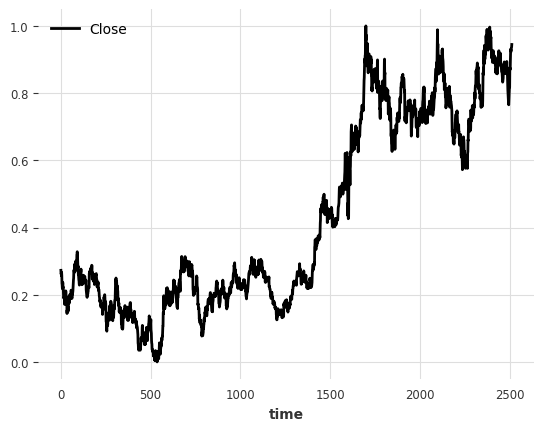

In [44]:
#Re-plot Gold 'Close' against time (for comparison to covariates)
g_series_sc2.plot(label='Close')

Text(0.5, 1.0, 'VIX inflation index covariate')

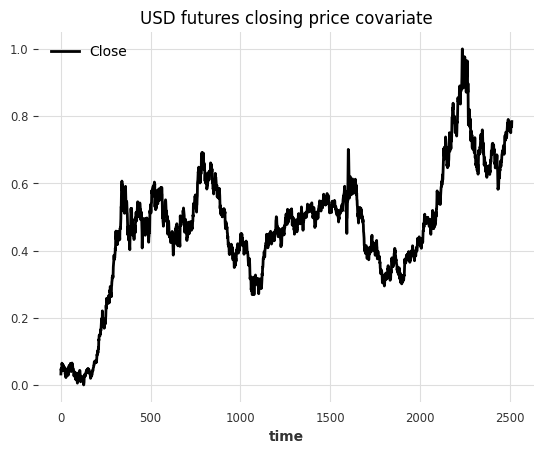

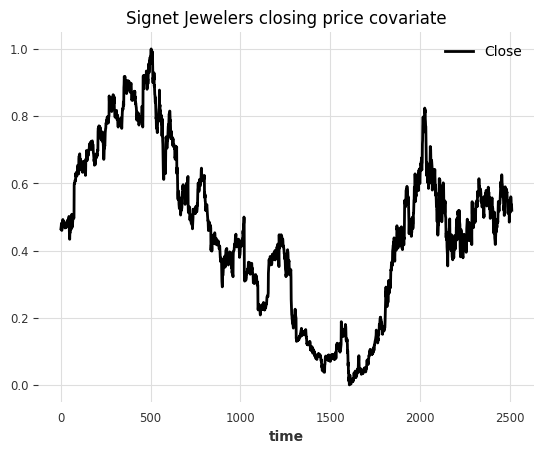

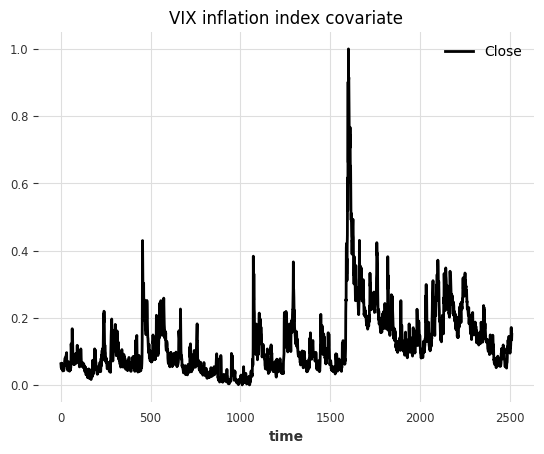

In [45]:
#Plot scaled covariates

plt.figure()
usd_covariates.plot()
plt.title("USD futures closing price covariate")

plt.figure()
sig_covariates.plot()
plt.title("Signet Jewelers closing price covariate")

plt.figure()
vix_covariates.plot()
plt.title("VIX inflation index covariate")

In [46]:
#Verify all Gold+Covariates TimeSeries lengths
print(len(g_tr_sc))
print(len(u_tr_sc))
print(len(s_tr_sc))
print(len(v_tr_sc))

print(len(g_te_sc))
print(len(u_te_sc))
print(len(s_te_sc))
print(len(v_te_sc))

print(len(g_series_sc2))
print(len(usd_covariates))
print(len(sig_covariates))
print(len(vix_covariates))

2447
2447
2447
2447
66
66
66
66
2513
2513
2513
2513


In [47]:
#Stack all scaled covariates into TimeSeries of 2512 x 3 dimensions

 #Stack Training Covariates
u_s_tr_sc = u_tr_sc.stack(s_tr_sc)
u_s_v_tr_sc = u_s_tr_sc.stack(v_tr_sc)
 #Stack Test Covariates
u_s_te_sc = u_te_sc.stack(s_te_sc)
u_s_v_te_sc = u_s_te_sc.stack(v_te_sc)
 #Stack full/concatenated Covariates
usd_sig_covariates = usd_covariates.stack(sig_covariates)
u_s_v_covariates = usd_sig_covariates.stack(vix_covariates)
 #Review full TimeSeries
u_s_v_covariates

<TimeSeries (DataArray) (time: 2513, component: 3, sample: 1)> Size: 60kB
array([[[0.03255924],
        [0.46451764],
        [0.06267844]],

       [[0.04822308],
        [0.46834726],
        [0.05628823]],

       [[0.043355  ],
        [0.47313425],
        [0.05152957]],

       ...,

       [[0.78044729],
        [0.53654859],
        [0.15268525]],

       [[0.76767562],
        [0.53105001],
        [0.13365056]],

       [[0.78371197],
        [0.51972956],
        [0.15023793]]])
Coordinates:
  * time       (time) int64 20kB 0 1 2 3 4 5 6 ... 2507 2508 2509 2510 2511 2512
  * component  (component) <U9 108B 'Close' 'Close_1' 'Close_1_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [48]:
#Verify scaled+stacked train/test TimeSeries lengths
print(len(g_tr_sc))
print(len(u_s_v_tr_sc))
print(len(g_te_sc))
print(len(u_s_v_te_sc))

2447
2447
66
66


In [49]:
#Model 5: BlockRNN model predicting prior 3 mo. prices in 2*33 trading day cycles (using covariate data)
model_name = "BlockRNN_pastcov"
model_pastcov33 = BlockRNNModel(
    model="LSTM",
    input_chunk_length=2414,
    output_chunk_length=33,
    n_epochs=200,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,  #store model states: latest + best performing of validation set
    force_reset=True,
    **generate_torch_kwargs()
)

In [50]:
#Fit training TimeSeries (Gold+Covariates)
model_pastcov33.fit(
    series=[g_tr_sc],
    past_covariates=[u_s_v_covariates],
    val_series=[g_series_sc2],
    val_past_covariates=[u_s_v_covariates],
)

Training: 0it [00:00, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=2414, output_chunk_length=33, n_epochs=200, random_state=42, model_name=BlockRNN_pastcov, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7e58be1ceb00>]})

In [51]:
#Load best model
best_pastcov33 = BlockRNNModel.load_from_checkpoint(model_name=model_name, best=True)

MAPE = 3.58%


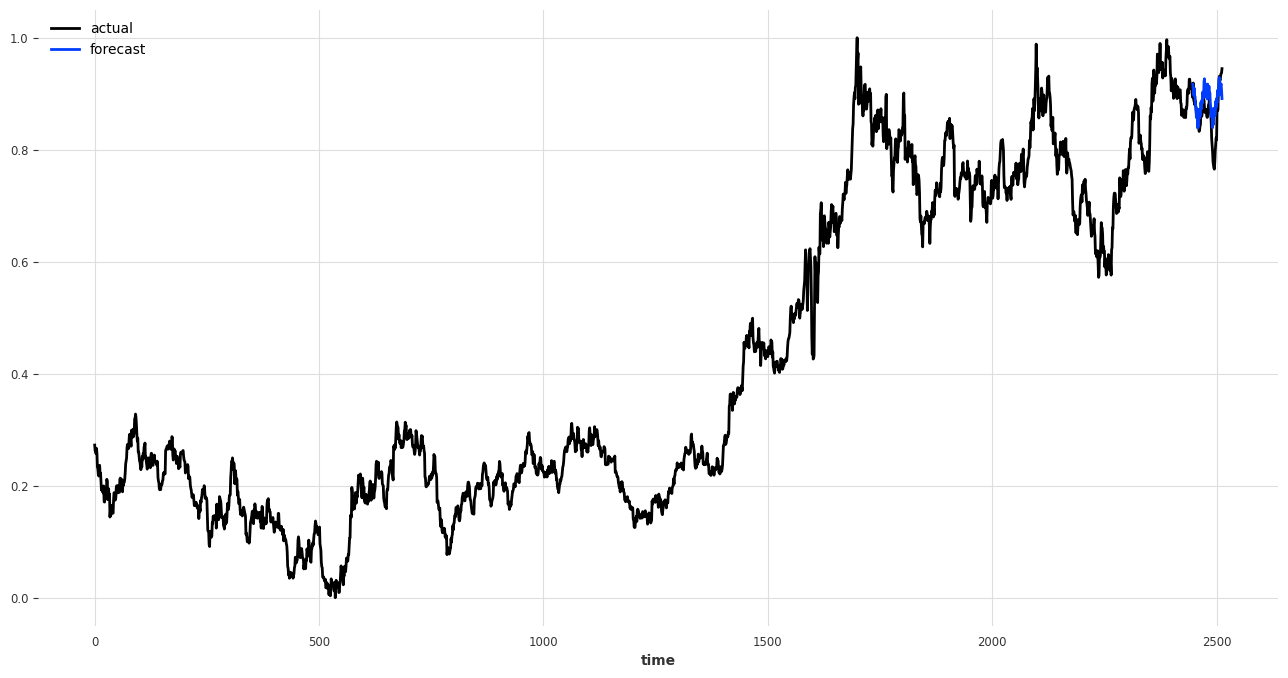

In [52]:
#Predict + score prediction error (Mean Average Percent Error) against scaled actuals
predPast33_cov = best_pastcov33.predict(n=66, series=g_tr_sc, past_covariates=[u_s_v_covariates])

plt.figure(figsize=(16,8))
g_series_sc2.plot(label="actual")
predPast33_cov.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(g_series_sc2, predPast33_cov)))

In [53]:
#Model 6: BlockRNN model predicting prior 3 mo. prices in 1*66 trading day cycle (using covariate data)
model_name2 = "BlockRNN_pastcov2"
model_pastcov66 = BlockRNNModel(
    model="LSTM",
    input_chunk_length=2381,
    output_chunk_length=66,
    n_epochs=200,
    random_state=42,
    model_name=model_name2,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs()
)

In [54]:
#Fit training TimeSeries (Gold+Covariates)
model_pastcov66.fit(
    series=[g_tr_sc],
    past_covariates=[u_s_v_covariates],
    val_series=[g_series_sc2],
    val_past_covariates=[u_s_v_covariates],
)

Training: 0it [00:00, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=2381, output_chunk_length=66, n_epochs=200, random_state=42, model_name=BlockRNN_pastcov2, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7e58bd232c20>]})

In [55]:
#Load best model
best_pastcov66 = BlockRNNModel.load_from_checkpoint(model_name=model_name2, best=True)

MAPE = 5.78%


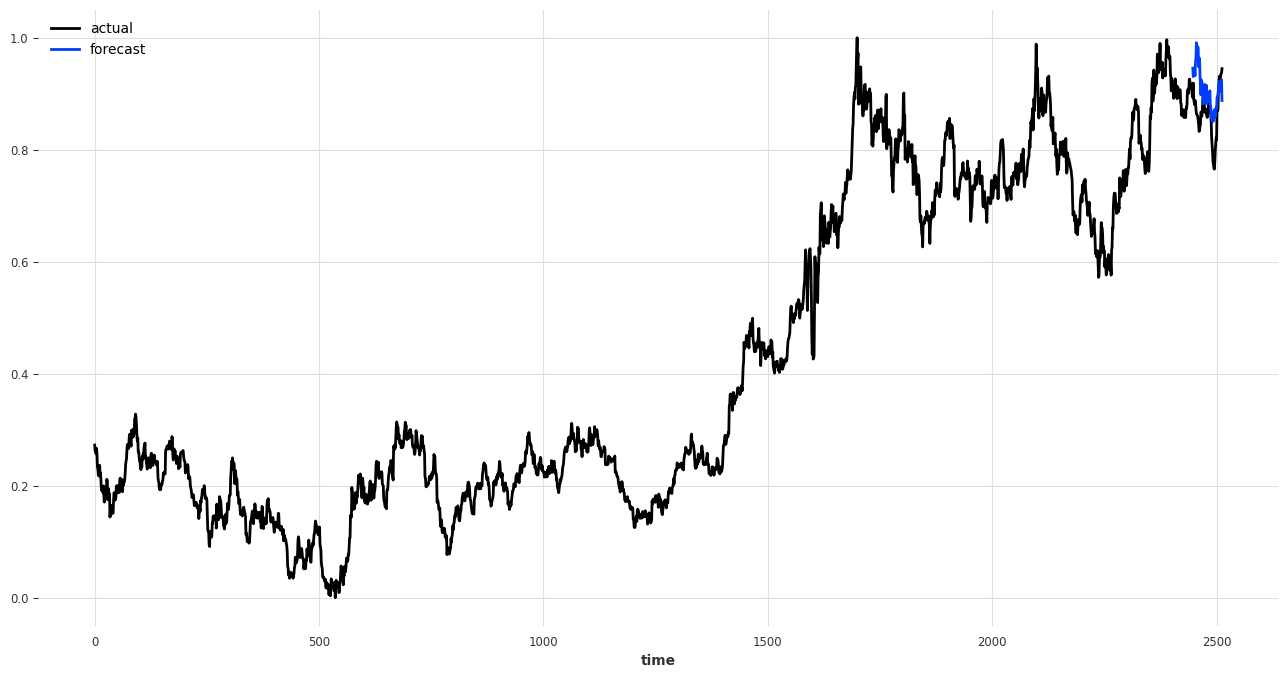

In [56]:
#Predict + score prediction error (Mean Average Percent Error) against scaled actuals
predPast66_cov = best_pastcov66.predict(n=66, series=g_tr_sc, past_covariates=[u_s_v_covariates])

plt.figure(figsize=(16,8))
g_series_sc2.plot(label="actual")
predPast66_cov.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(g_series_sc2, predPast66_cov)))

결론

결과 및 평가

모델과 예측 기간 전반에서 MAPE 값은 6.34%에서 3.58% 범위로 나타났습니다.
일반적으로, 66일 단위 예측보다 33일 단위 두 번의 예측에서 오류가 더 적게 발생했습니다.
또한, 각 기간 내에서 선택한 3개의 공변량을 사용하여 모델을 학습시키면 오류가 더 감소했습니다.

33일: 약 0.7 MAPE
66일: 약 0.55 MAPE
수정 및 추가 분석

하이퍼파라미터(예: 뉴런 드롭아웃)를 조정하여 모델 성능 최적화
동적 날짜 설정: 코드 실행 시 현재 날짜를 기준으로 기간을 예측
기본 BlockRNN 점수 확보(공변량 없음)
BlockRNN의 향후 예측
'3개월 후' 세트 날짜(2023년 11월 1일 - 2024년 1월 31일, 62 거래일)에 대한 현재 예측 점수, 데이터 이용 가능 시